# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter
import pickle 
import glob
import shutil
import os
import requests
import shutil
import urllib

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import imread, imshow, subplots, show
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 
import warnings
warnings.simplefilter('ignore')

import pylab as pl

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.data import DataLoader,Dataset
import torch.optim as optim

from os import listdir
from os.path import isfile, join

from tqdm.auto import tqdm
import os
from PIL import Image
import cv2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

<ipython-input-1-48741e596def>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn')


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Preprocessing

In [ ]:
with open('/content/drive/My Drive/Diploma/CODE/data/new_eng_data.pkl', 'rb') as f:
    df = pickle.load(f)

In [ ]:
df.shape

(8784, 40)

In [ ]:
df.columns

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'has_oscar_actor',
       'has_oscar_composer', 'has_oscar_design', 'has_oscar_director',
       'has_oscar_editor', 'has_oscar_operator', 'has_oscar_producer',
       'has_oscar_writer', 'poster_url', 'poster_url_preview', 'has_imax',
       'has_3_d', 'has_sequel'],
      dtype='object')

In [ ]:
len(df['poster_url_preview'].unique())

8699

In [ ]:
# add names of imgs

def add_img_name(data):
    return data.split('/')[-1]

df['img_name'] = df['poster_url_preview'].apply(add_img_name)

df.head().T[-5:]

,0,1,2,3,4
poster_url_preview,https://kinopoiskapiunofficial.tech/images/posters/kp_small/6580.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/6460.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/1228112.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/623934.jpg,https://kinopoiskapiunofficial.tech/images/posters/kp_small/1172958.jpg
has_imax,False,False,False,False,False
has_3_d,False,False,False,False,False
has_sequel,1,1,0,0,0
img_name,6580.jpg,6460.jpg,1228112.jpg,623934.jpg,1172958.jpg


In [ ]:
import ast

columns = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
                      'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
for col in columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if not isinstance(x, float) else np.nan)

In [ ]:
cols_na = ['ACTOR', 'COMPOSER',
                 'DESIGN', 'DIRECTOR', 
                 'EDITOR', 'OPERATOR', 
                 'PRODUCER', 'WRITER']

df.dropna(subset=cols_na, inplace=True)

In [ ]:
def add_topN_feature(df, col, n: int):
    items = []
    
    for i in df[col]:
        items.extend(i)

    topN = [x[0] for x in Counter(items).most_common()][:n]
    df[f'top{n}{col}'] = df[col].apply(lambda x: [int(item in x) for item in topN])
    df.drop(col, axis=1, inplace=True)
    return topN, f'top{n}{col}'

def ohe_topN_features(df, topN, cat):
    for i in range(len(topN)):
        df[f'{topN[i]}'] = [item[i] for item in df[cat]]
    df.drop(cat, axis=1, inplace=True)
    return df

In [ ]:
top10genres, name = add_topN_feature(df, 'genre', 10)
df = ohe_topN_features(df, top10genres, name)

top10actors, name = add_topN_feature(df, 'ACTOR', 10)
df = ohe_topN_features(df, top10actors, name)

top3directors, name = add_topN_feature(df, 'COMPOSER', 3)
df = ohe_topN_features(df, top3directors, name)

top5countries, name = add_topN_feature(df, 'country', 5)
df = ohe_topN_features(df, top5countries, name)

top2DESIGN, name = add_topN_feature(df, 'DESIGN', 2)
df = ohe_topN_features(df, top2DESIGN, name)

top2DIRECTOR, name = add_topN_feature(df, 'DIRECTOR', 2)
df = ohe_topN_features(df, top2DIRECTOR, name)

top2EDITOR, name = add_topN_feature(df, 'EDITOR', 2)
df = ohe_topN_features(df, top2EDITOR, name)

top2OPERATOR, name = add_topN_feature(df, 'OPERATOR', 2)
df = ohe_topN_features(df, top2OPERATOR, name)

top3PRODUCER, name = add_topN_feature(df, 'PRODUCER', 3)
df = ohe_topN_features(df, top3PRODUCER, name)

top2WRITER, name = add_topN_feature(df, 'WRITER', 2)
df = ohe_topN_features(df, top2WRITER, name)

df.head().T

,0,1,4,5,6
age_access_type,12,16,6,16,12
name,Звёздный путь 5: Последний рубеж,Звёздный путь 6: Неоткрытая страна,Пламенное сердце,Роман с кукушкой,Звёздный путь 2: Гнев Хана
director,['cff3362f-ad91-498d-80b3-ea3ab8ec65cf'],['bab6b7f4-4506-458f-9091-d567505674f2'],"['40f78e6d-3c9f-434f-a505-c6ffdd045763', '332105c2-2697-49fd-97b2-b5022577758c']",['f5fba6fe-94b3-4e69-acfc-da6867320386'],['bab6b7f4-4506-458f-9091-d567505674f2']
average_rating,6.21,7.2,6.4,NaN,7.45
type,MOVIE,MOVIE,MOVIE,MOVIE,MOVIE
...,...,...,...,...,...
Харви Вайнштейн,0,0,0,0,0
Боб Вайнштейн,0,0,0,0,0
Арнон Милчен,0,0,0,0,0
Люк Бессон,0,0,0,0,0


In [ ]:
prep_df = df.copy(deep=True)

In [ ]:
skewed_num_features = ['duration', 'BUDGET', 'MARKETING',
                       'RUS', 'USA', 'WORLD']

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

class Preprocesser:
    def __init__(self, 
#                 mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
#                 mltpl_cat_n_top: dict
                ):
#         self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
#         self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
#         df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [ ]:
preprocesser = Preprocesser(
#     mltpl_cat_features,
            skewed_num_features,
            #text_features,
#             mltpl_cat_n_top
                           )

In [ ]:
df_pr = preprocesser.preprocess(prep_df)

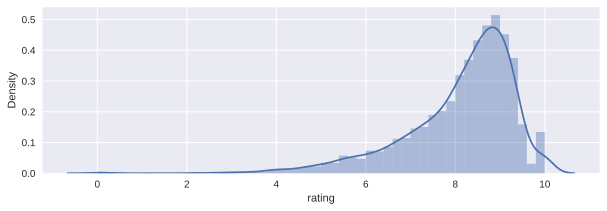

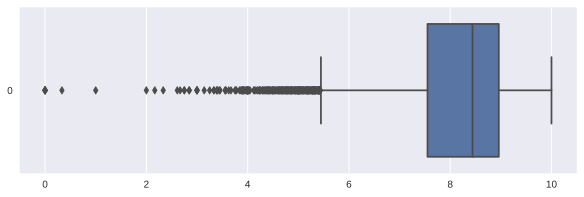

In [ ]:
plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

### Test/Train split

In [ ]:
train_df = df[df['release_year'] != 2022]

In [ ]:
train_df.shape

(5785, 72)

In [ ]:
train_df.dropna(subset=['rating'], inplace=True)
train_df.shape

(5785, 72)

In [ ]:
test_df = df[df['release_year'] == 2022]
test_df.shape

(68, 72)

In [ ]:
test_df.dropna(subset=['rating'], inplace=True)
test_df.shape

(68, 72)

### Preproc

In [ ]:
train = train_df.copy(deep=True)
test = test_df.copy(deep=True)

In [ ]:
train = train[train['release_year'] >= 2000]

In [ ]:
train.shape

(4752, 72)

In [ ]:
train.columns[:30]

Index(['age_access_type', 'name', 'director', 'average_rating', 'type',
       'release_type', 'release_year', 'duration', 'actor', 'element_uid',
       'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD', 'element_id', 'rating',
       'has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
       'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
       'has_oscar_producer', 'has_oscar_writer', 'poster_url',
       'poster_url_preview', 'has_imax', 'has_3_d', 'has_sequel'],
      dtype='object')

In [ ]:
train.columns[30:73]

Index(['img_name', 'Drama', 'Comedy', 'Thriller', 'Action',
       '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли'],
      dtype='object')

In [ ]:
drop_cols = ['name', 'director', 'average_rating', 'release_type', 'release_year', 'actor',
             'element_uid', 'element_id', 'poster_url', 'poster_url_preview']

In [ ]:
train.drop(drop_cols, axis=1, inplace=True)

test.drop(drop_cols, axis=1, inplace=True)

In [ ]:
train.shape, test.shape

((4752, 62), (68, 62))

In [ ]:
#  ohe: age_access_type, type
# standart sc: duration, BUDGET, MARKETING, RUS, USA, WORLD
# drop: 

In [ ]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# ohe
from sklearn.preprocessing import OneHotEncoder

ohe_cols = ['age_access_type', 'type']

oenc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_train = oenc.fit_transform(train[ohe_cols])

# enc_train = enc_train.toarray()

enc_train = pd.DataFrame(enc_train,columns=oenc.get_feature_names_out())

train = pd.concat([train, enc_train],axis=1)

train.drop(ohe_cols, axis=1, inplace=True)
# 
enc_test = oenc.transform(test[ohe_cols])

# enc_test= enc_test.toarray()

enc_test = pd.DataFrame(enc_test,columns=oenc.get_feature_names_out())

test = pd.concat([test, enc_test],axis=1) 

test.drop(ohe_cols, axis=1, inplace=True)

In [ ]:
train.head().T[-50:]

,5,11,16,19,20
img_name,1038800.jpg,255129.jpg,734349.jpg,321.jpg,455165.jpg
Drama,1.0,0.0,0.0,0.0,0.0
Comedy,1.0,0.0,0.0,0.0,0.0
Thriller,0.0,1.0,1.0,1.0,0.0
Action,0.0,1.0,1.0,1.0,1.0
364fdc2e-bdfe-40be-b2c5-d30f43ec432e,0.0,0.0,0.0,0.0,0.0
Adventure,0.0,1.0,0.0,1.0,1.0
Sci-Fi,0.0,1.0,1.0,1.0,1.0
Melodrama,1.0,0.0,0.0,0.0,0.0
Horror,0.0,0.0,0.0,0.0,0.0


In [ ]:
train.shape, test.shape

((6447, 68), (133, 68))

### Standartization

In [ ]:
# sc
from sklearn.preprocessing import StandardScaler

sc_cols = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD']

sc=StandardScaler()
sc_train = sc.fit_transform(train[sc_cols])

sc_train = pd.DataFrame(sc_train,columns=sc_cols)
train.drop(sc_cols, axis=1, inplace=True)
train = pd.concat([train, sc_train],axis=1)

# 
sc_test = sc.transform(test[sc_cols])

sc_test = pd.DataFrame(sc_test,columns=sc_cols)
test.drop(sc_cols, axis=1, inplace=True)

test = pd.concat([test, sc_test],axis=1) 



In [ ]:
train.head().T[-50:]

,5,11,16,19,20
Adventure,0.0,1.0,0.0,1.0,1.0
Sci-Fi,0.0,1.0,1.0,1.0,1.0
Melodrama,1.0,0.0,0.0,0.0,0.0
Horror,0.0,0.0,0.0,0.0,0.0
9fa28b61-a257-4a3e-945b-a9ef76a146d6,0.0,0.0,0.0,0.0,0.0
Бернард Коллако,0.0,0.0,0.0,0.0,0.0
Марк Фальво,0.0,0.0,0.0,0.0,0.0
Джимми Стар,0.0,0.0,0.0,0.0,0.0
Брюс Уиллис,0.0,0.0,0.0,0.0,0.0
Роджер Бреннер,0.0,0.0,0.0,0.0,0.0


In [ ]:
fls = None 
for root_dir, cur_dir, files in os.walk(r'/content/drive/My Drive/Diploma/CODE/covers/'):
    fls = files
    
len(fls)

10367

In [ ]:
print(train.shape)
train_pr = train[train['img_name'].isin(fls)]
train_pr.shape

(7270, 68)


(4752, 68)

In [ ]:
tst_fls = None 
for root_dir, cur_dir, files in os.walk(r'/content/drive/My Drive/Diploma/CODE/covers/'):
    tst_fls = files

In [ ]:
len(tst_fls)

10367

In [ ]:
print(test.shape)
test_pr = test[test['img_name'].isin(tst_fls)]
test_pr.shape

(198, 68)


(68, 68)

In [ ]:
# fls = None 
# for root_dir, cur_dir, files in os.walk(r'/content/drive/My Drive/Diploma/CODE/train_cvrs/'):
#     fls = files
    
# len(fls)

7892

In [ ]:
# print(train.shape)
# train_pr = train[train['img_name'].isin(fls)]
# train_pr.shape

(7270, 68)


(4658, 68)

In [ ]:
# tst_fls = None 
# for root_dir, cur_dir, files in os.walk(r'/content/drive/My Drive/Diploma/CODE/test_covers/'):
#     tst_fls = files

In [ ]:
# len(tst_fls)

97

In [ ]:
# print(test.shape)
# test_pr = test[test['img_name'].isin(tst_fls)]
# test_pr.shape

(198, 68)


(47, 68)

**Save preproc dfs**

In [ ]:


# with open('/root/User/_DIPLOMA/data/preproc_dfs/train_pr_oscr_ohe_new.pkl', 'wb') as f:
#     pickle.dump(train_pr, f)

# with open('/root/User/_DIPLOMA/data/preproc_dfs/test_pr_oscr_ohe_new.pkl', 'wb') as f:
#     pickle.dump(test_pr, f)

**Load datasets**

In [ ]:
# with open('/root/User/_DIPLOMA/data/preproc_dfs/train_pr_oscr_ohe_new.pkl', 'rb') as f:
#     train_pr = pickle.load(f, encoding='utf-8')

In [ ]:
# with open('/root/User/_DIPLOMA/data/preproc_dfs/test_pr_oscr_ohe_new.pkl', 'rb') as f:
#     test_pr = pickle.load(f, encoding='utf-8')

In [ ]:
test_pr.head().T

,4,13,46,1020,2836
rating,9.282869,8.9459,8.626496,5.504337,9.417652
has_oscar_actor,0.0,0.0,0.0,0.0,0.0
has_oscar_composer,0.0,0.0,0.0,0.0,0.0
has_oscar_design,0.0,0.0,0.0,0.0,0.0
has_oscar_director,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
BUDGET,NaN,NaN,NaN,NaN,NaN
MARKETING,NaN,NaN,NaN,NaN,NaN
RUS,0.129165,NaN,NaN,NaN,NaN
USA,0.171812,NaN,NaN,NaN,NaN


In [ ]:
test_pr.columns

Index(['rating', 'has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
       'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
       'has_oscar_producer', 'has_oscar_writer', 'has_imax', 'has_3_d',
       'has_sequel', 'img_name', 'Drama', 'Comedy', 'Thriller', 'Action',
       '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли', 'age_access_type_0',
       'age_

In [ ]:
train_pr.isna().sum()[50:100]

Боб Вайнштейн            0
Арнон Милчен             0
Люк Бессон               0
Стэн Ли                  0
age_access_type_0     1695
age_access_type_6     1695
age_access_type_12    1695
age_access_type_16    1695
age_access_type_18    1695
type_MOVIE            1695
type_MP_MOVIE         1695
type_SERIAL           1695
duration              1695
BUDGET                3335
MARKETING             4601
RUS                   3163
USA                   3090
WORLD                 2503
dtype: int64

In [ ]:
train_new = train_pr.drop([
'age_access_type_0',
'age_access_type_6',
'age_access_type_12',
'age_access_type_16',
'age_access_type_18',
'type_MOVIE',
'type_MP_MOVIE',
'type_SERIAL',
'duration',
'BUDGET',
'MARKETING',
'RUS',
'USA',
'WORLD',
'img_name',
'rating'], axis=1)

test_new = test_pr.drop([
'age_access_type_0',
'age_access_type_6',
'age_access_type_12',
'age_access_type_16',
'age_access_type_18',
'type_MOVIE',
'type_MP_MOVIE',
'type_SERIAL',
'duration',
'BUDGET',
'MARKETING',
'RUS',
'USA',
'WORLD', 
'img_name',
'rating'], axis=1)

In [ ]:
train_img = train_pr[['img_name']]

test_img = test_pr[['img_name']]

y_train = train_pr[['rating']]
y_test = test_pr[['rating']]

In [ ]:
train_new.columns

Index(['has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
       'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
       'has_oscar_producer', 'has_oscar_writer', 'has_imax', 'has_3_d',
       'has_sequel', 'Drama', 'Comedy', 'Thriller', 'Action',
       '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли'],
      dtype='object')

# Remove outliers

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# model = IsolationForest(random_state=47)

# param_grid = {'n_estimators': [1000, 1500], 
#               'max_samples': [10], 
#               'contamination': ['auto', 0.0001, 0.0002], 
#               'max_features': [10, 15], 
#               'bootstrap': [True], 
#               'n_jobs': [-1]}

# grid_search = model_selection.GridSearchCV(model, 
#                                            param_grid,
#                                            scoring="neg_mean_squared_error", 
#                                            refit=True,
#                                            cv=10, 
#                                            return_train_score=True)
# grid_search.fit(train_new, y_train)

# best_model = grid_search.fit(train_new, y_train)
# print('Optimum parameters', best_model.best_params_)

Optimum parameters {'bootstrap': True, 'contamination': 0.0001, 'max_features': 10, 'max_samples': 10, 'n_estimators': 1000, 'n_jobs': -1}


In [ ]:
iforest = IsolationForest(bootstrap=True,
                          contamination=0.0001, 
                          max_features=10, 
                          max_samples=10, 
                          n_estimators=1000, 
                          n_jobs=-1,
                         random_state=1)
y_pred = iforest.fit_predict(train_new)

**Remove the outliers**

In [ ]:
train_new.shape

(4752, 52)

In [ ]:
train_new['TARGET'] = y_train.values
train_new['PREDS'] = y_pred.tolist()

In [ ]:
train_new['PREDS'].value_counts()

 1    4751
-1       1
Name: PREDS, dtype: int64

In [ ]:
train_new['img_name'] = train_img.values
test_new['img_name'] = test_img.values

train_new['rating'] = y_train
test_new['rating'] = y_test

In [ ]:
train_new = train_new[train_new['PREDS'] == 1]

In [ ]:
train_new.drop(['TARGET', 'PREDS'], axis=1, inplace=True)

In [ ]:
train_new.columns

Index(['has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
       'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
       'has_oscar_producer', 'has_oscar_writer', 'has_imax', 'has_3_d',
       'has_sequel', 'Drama', 'Comedy', 'Thriller', 'Action',
       '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
       'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
       'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
       'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
       'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
       'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
       'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
       'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
       'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
       'Арнон Милчен', 'Люк Бессон', 'Стэн Ли', 'img_name', 'rating'],
      dtype='object')

# PyTorch

In [ ]:
!pip install pytorch_lightning #==1.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


data_path = "./data/"

In [ ]:
class ImageDataset(Dataset):
    """Tabular and Image dataset."""

    def __init__(self, df, image_dir):
        self.image_dir = image_dir
        self.tabular = df 
        self.RESCALE_SIZE = 128

    def __len__(self):
        return self.tabular.shape[0]
    def _prepare_sample(self, image):

        image = image.resize((self.RESCALE_SIZE, self.RESCALE_SIZE))
        return np.array(image)

    def __getitem__(self, idx):
        tabular = self.tabular.iloc[idx, 0:]

        y = tabular["rating"]

        image = Image.open(f"{self.image_dir}/{tabular['img_name']}").convert('RGB')
        image.load()
        image = self._prepare_sample(image)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        image = np.array(image / 255, dtype='float32')
        image = transform(image)
        # image = np.array(image)
        # image = image[..., :3]

        # image = transforms.functional.to_tensor(image)

        tabular = tabular[['has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
                           'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
                           'has_oscar_producer', 'has_oscar_writer', 'has_imax', 'has_3_d',
                           'has_sequel', 'Drama', 'Comedy', 'Thriller', 'Action',
                           '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
                           'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
                           'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
                           'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
                           'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
                           'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
                           'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
                           'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
                           'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
                           'Арнон Милчен', 'Люк Бессон', 'Стэн Ли']] # 'x0_0', 'x0_6', 'x0_12',
                            # 'x0_16', 'x0_18', 'x1_MOVIE', 'x1_MP_MOVIE', 'x1_SERIAL', 'duration',
                            # 'BUDGET', 'MARKETING', 'RUS', 'USA', 'WORLD'
        tabular = tabular.tolist()
        tabular = torch.FloatTensor(tabular)

        return image, tabular, y

In [ ]:
a = ['has_oscar_actor', 'has_oscar_composer', 'has_oscar_design',
                           'has_oscar_director', 'has_oscar_editor', 'has_oscar_operator',
                           'has_oscar_producer', 'has_oscar_writer', 'has_imax', 'has_3_d',
                           'has_sequel', 'Drama', 'Comedy', 'Thriller', 'Action',
                           '364fdc2e-bdfe-40be-b2c5-d30f43ec432e', 'Adventure', 'Sci-Fi',
                           'Melodrama', 'Horror', '9fa28b61-a257-4a3e-945b-a9ef76a146d6',
                           'Бернард Коллако', 'Марк Фальво', 'Джимми Стар', 'Брюс Уиллис',
                           'Роджер Бреннер', 'Крис Уилсон', 'Розмари Ховард', 'Ласко Аткинс',
                           'Кадролша Она Кароле', 'Дэнни Трехо', 'Джон Дебни',
                           'Джеймс Ньютон Ховард', 'Марко Белтрами', 'usa', 'great-britain',
                           'france', 'germany', 'canada', 'Эллен Мирожник', 'Энн Рот',
                           'Стивен Спилберг', 'Такер Гейтс', 'Майкл Кан', 'Крис Гилл',
                           'Роджер Дикинс', 'Джим Дено', 'Харви Вайнштейн', 'Боб Вайнштейн',
                           'Арнон Милчен', 'Люк Бессон', 'Стэн Ли']

len(a)

52

In [ ]:
train_new.shape

(4751, 54)

## Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


In [ ]:
def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))

    model_state_dict = model.state_dict().copy()

    torch.save({'iteration': iteration,
                'state_dict': model_state_dict,
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)

In [ ]:
def train(model, optimizer, criterion, 
          train_loader, val_loader, 
          epochs=100, iter_per_validation=50,
          checkpoint_path="./best_checkpoint",
          save_by="accuracy"):
  iteration = 0
  loss_list = []
  iteration_list = []
  accuracy_list = []
  best_score = None

  for epoch in range(epochs):
      print(f"Epoch {epoch}")
      for images, tabular, labels in train_loader:

          model.train()
          # Clear gradients
          optimizer.zero_grad()
          
          # Forward propagation
          images = images.to(device, dtype=torch.float)
          tabular = tabular.to(device, dtype=torch.float)
          labels = labels.to(device, dtype=torch.long)
          outputs = model(images, tabular)
          
          # Calculate softmax and ross entropy loss
          loss = criterion(outputs, labels)
          
          # Calculating gradients
          loss.backward()
          
          # Update parameters
          optimizer.step()
          
          iteration += 1
          
          if iteration % iter_per_validation == 0:
              model.eval()
              with torch.no_grad():
                # Calculate Accuracy         
                correct = 0
                total = 0

                
                # Iterate through val dataset
                for images, tabular, labels in val_loader:

                    images = images.cuda() #.to(device, dtype=torch.float)
                    tabular = tabular.cuda() #.to(device, dtype=torch.float)
                    labels = labels.cuda() #.to(device, dtype=torch.long)
                    
                    # Forward propagation
                    outputs = model(images, tabular)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]
                    
                    # Total number of labels
                    total += len(labels)
                    
                    correct += (predicted == labels).sum()
                
                accuracy = 100 * correct / float(total)
            
                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(iteration)
                accuracy_list.append(accuracy)
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(iteration, loss.data, accuracy))

                # save if we have best model state
                ref_score = accuracy if save_by == "accuracy" else loss.data
                compare = (lambda x, y: x > y) if save_by == "accuracy" else (lambda x, y: x < y)
                if best_score is None or compare(ref_score, best_score):
                    best_score = ref_score
                    save_checkpoint(model, optimizer, 
                                    optimizer.state_dict()['param_groups'][0]['lr'], 
                                    iteration, checkpoint_path)

  return iteration_list, loss_list, accuracy_list

In [ ]:
test_new.isna().sum().sum()

0

In [ ]:
# image_data_train = ImageDataset(df=train_new, image_dir='/content/drive/My Drive/Diploma/CODE/covers/')

# test_set = ImageDataset(df=test_new, image_dir='/content/drive/My Drive/Diploma/CODE/covers')

# train_set, test_dddd, val_set = random_split(image_data_train, [4000, 0, 657])
# len(train_set), len(test_set), len(val_set)


image_data_train = ImageDataset(df=train_new, image_dir='/content/drive/My Drive/Diploma/CODE/covers/')

test_set = ImageDataset(df=test_new, image_dir='/content/drive/My Drive/Diploma/CODE/covers')

train_set, test_dddd, val_set = random_split(image_data_train, [4000, 0, 751])
len(train_set), len(test_set), len(val_set)

(4000, 68, 751)

In [ ]:
BATCH_SIZE = 16

In [ ]:
train_loader = DataLoader(
    train_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_set, 
    batch_size=BATCH_SIZE,
    shuffle=True
)


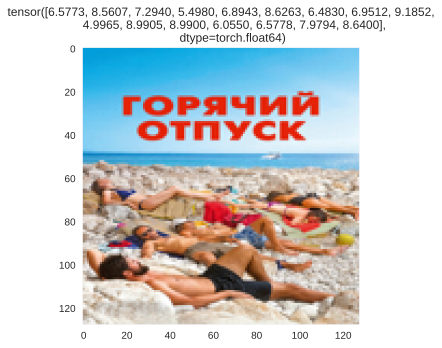

In [ ]:
def imshow(inp, title=None, default=False):
    """Imshow для тензоров"""
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    
    inp = inp[0].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    a.imshow(inp)
    if title is not None:
        a.set_title(title)
    a.grid(False)


for im_val, tab, label in test_loader:
  imshow(im_val.data.cpu(), \
        title=label)
  break


## RESNET50

In [ ]:
import torchvision.models as models
from torchsummary import summary

In [ ]:
resnet50 = models.resnet18(pretrained=True).to(device)

**Freezed layers**

In [ ]:
def set_parameter_requires_grad(model, freeze=False):
  for param in model.parameters():
    param.requires_grad = not freeze

In [ ]:
set_parameter_requires_grad(resnet50, freeze=True)

Change output layer

In [ ]:
# resnet50.fc.requires_grad_(True)
# resnet50.fc = nn.Linear(in_features=64, out_features=10).to(device)

In [ ]:
class RatingPredictor(nn.Module):
    def __init__(self):
        super().__init__()

        resnet50.fc = nn.Linear(in_features=512, out_features=32)
        resnet50.fc.requires_grad_(True)
        self.resnet = resnet50

        self.ln4 = nn.Linear(52, 32)
        self.relu1 = nn.ReLU()
        self.ln5 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.ln6 = nn.Linear(16, 5)
        self.relu3 = nn.ReLU()
        self.ln7 = nn.Linear(37, 1)
        self.relu4 = nn.ReLU()

    def forward(self, img, tab):
        img = self.resnet(img)
        # print(f'img: {img.shape}')
        img = img.reshape(img.shape[0], -1)
        # print(f'img: {img.shape}')

        tab = self.ln4(tab)
        tab = self.relu1(tab)
        tab = self.ln5(tab)
        tab = self.relu2(tab)
        tab = self.ln6(tab)
        tab = self.relu3(tab)
        # print(f'tab: {tab.shape}')
        x = torch.cat((img, tab), dim=1)
        # print(f'X SHAPE: {x.shape}')
        x = self.relu4(x)

        return self.ln7(x)
    
    def training_step(self, batch):
        inputs, tabular, targets = batch 
        inputs = inputs.cuda() #.to(device, dtype=torch.float)
        tabular = tabular.cuda() #.to(device, dtype=torch.float)
        targets = targets.cuda() #.to(device, dtype=torch.long)

        # Generate predictions
        out = self(inputs, tabular)       
        # Calcuate loss
        loss = F.l1_loss(out, targets)                
        return loss

    def validation_step(self, batch):
        inputs, tabular, targets = batch
        inputs = inputs.cuda() #.to(device, dtype=torch.float)
        tabular = tabular.cuda() #.to(device, dtype=torch.float)
        targets = targets.cuda() #.to(device, dtype=torch.long)

        # Generate predictions
        out = self(inputs, tabular)
        # Calculate loss
        loss = F.l1_loss(out, targets) 
        acc = accuracy(out,targets)                   
        return {'val_loss': loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
    def epoch_end(self, epoch, result, num_epochs):
      if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
        print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

**Train**

In [ ]:
criterion = nn.L1Loss()

# Hyper parameters
learning_rate = 0.001 

# Adam Optimizer
optimizer = torch.optim.AdamW(resnet50.parameters(), lr=learning_rate)
ls_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

model_res = RatingPredictor().to(device)

In [ ]:
def accuracy(output,labels):
    _,preds =torch.max(output,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
def evaluate(model, val_loader):
    model.eval() #
    with torch.no_grad(): #
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

def train(epochs, lr, model, train_loader, val_loader, optimizer, ls_scheduler):  # train
    history = []
    # optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() #
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            ls_scheduler.step()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)

    return history

In [ ]:
history = [evaluate(model_res, val_loader)]
print(history)

[{'val_loss': 7.877601585382727, 'val_acc': 0.002659574383869767}]


In [ ]:
epochs = 5

history += train(epochs, learning_rate, model_res, 
                 train_loader, val_loader, optimizer, ls_scheduler)

Epoch [5], val_loss: 7.8808


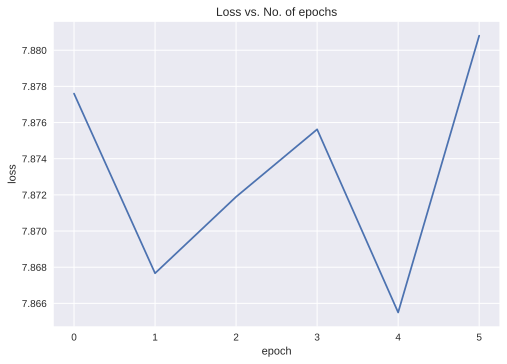

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
test_imgs, test_tabular, test_lbls = next(iter(test_loader))
test_imgs = test_imgs.cuda()
test_tabular = test_tabular.cuda()
test_lbls = test_lbls.cuda()

with torch.no_grad(): 
    preds = model_res(test_imgs, test_tabular)

In [ ]:
yhat=preds.flatten().to('cpu')  # [1]
yhat

tensor([ 0.0659,  0.0478,  0.0820,  0.1040,  0.2946,  0.1745, -0.1170,  0.1031,
        -0.0103,  0.1453,  0.0634,  0.3200, -0.0512,  0.3185,  0.0672,  0.0973])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_errors_and_r2(y_true, y_pred):
    mean_squared_err = (mean_squared_error(y_true, y_pred))
    root_mean_squared_err = np.sqrt(mean_squared_err)
    mae = (mean_absolute_error(y_true, y_pred))
    r2 = round(r2_score(y_true, y_pred)*100,0)
    return mean_squared_err, root_mean_squared_err, mae, r2

In [ ]:
test_mean_squared_error, test_root_mean_squared_error,test_mae, test_r2_score_percentage = calculate_errors_and_r2(test_lbls.to('cpu'), yhat)

print('Test Data MSE = ', test_mean_squared_error)
print('Test Data RMSE = ', test_root_mean_squared_error)
print('Test Data MAE = ', test_mae)
print('Test Data R2 = ', test_r2_score_percentage)

Test Data MSE =  60.8709932851105
Test Data RMSE =  7.801986496086141
Test Data MAE =  7.650624741604016
Test Data R2 =  -2661.0


In [ ]:
torch.save(model_res.state_dict(), '/content/drive/My Drive/Diploma/CODE/data/models/model_resnet18_v1.pth')

In [ ]:
# it, losses, acs = train(model_res, optimizer,
#                         criterion, train_loader, 
#                         val_loader, epochs, 
#                         checkpoint_path='./resnet18_best_checkpoint')

Epoch 0
Iteration: 50  Loss: 7.3178324699401855  Accuracy: 0.4566210210323334 %
Saving model and optimizer state at iteration 50 to ./resnet18_best_checkpoint


KeyboardInterrupt: ignored

## **CNN Architecture**

In [ ]:
def conv_block(input_size, output_size):
    block = nn.Sequential(
        nn.Conv2d(input_size, output_size, (3, 3)), 
        nn.ReLU(),
        nn.BatchNorm2d(output_size),
        nn.MaxPool2d((2, 2)),
    )

    return block

In [ ]:
def accuracy(output,labels):
    _,preds =torch.max(output,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [ ]:
# class RatingPredictor(nn.Module):
#     def __init__(
#         self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 16,
#     ):
#         super().__init__()
#         self.lr = lr
#         self.num_workers = num_workers
#         self.batch_size = batch_size

#         self.conv1 = conv_block(3, 16)
#         self.conv2 = conv_block(16, 32)
#         self.conv3 = conv_block(32, 64)

#         self.ln1 = nn.Linear(64 * 6 * 6, 16)
#         self.relu = nn.ReLU()
#         self.batchnorm = nn.BatchNorm1d(16)
# #         self.dropout = nn.Dropout2d(0.5) ########
#         self.ln2 = nn.Linear(16, 5)

# #         self.ln4 = nn.Linear(49, 10)
#         self.ln4 = nn.Linear(49, 5)
# #         self.ln5 = nn.Linear(10, 10)
# #         self.ln6 = nn.Linear(10, 5)
#         self.ln7 = nn.Linear(10, 1)

#     def forward(self, img, tab):
#         img = self.conv1(img)
#         img = self.conv2(img)
#         img = self.conv3(img)

#         img = img.reshape(img.shape[0], -1)
#         img = self.ln1(img)
#         img = self.relu(img)
#         img = self.batchnorm(img)
# #         img = self.dropout(img)
#         img = self.ln2(img)
#         img = self.relu(img)
        
#         tab = self.ln4(tab)
#         tab = self.relu(tab)
# #         tab = self.ln5(tab)
# #         tab = self.relu(tab)
# #         tab = self.ln6(tab)
# #         tab = self.relu(tab)
       
#         x = torch.cat((img, tab), dim=1)
#         x = self.relu(x)

#         return self.ln7(x)
    
#     def training_step(self, batch):
#         inputs, tabular, targets = batch 
#         # Generate predictions
#         out = self(inputs, tabular)        
#         # Calcuate loss
#         loss = F.l1_loss(out, targets)                
#         return loss

#     def validation_step(self, batch):
#         inputs, tabular, targets = batch
#         # Generate predictions
#         out = self(inputs, tabular)
#         # Calculate loss
#         loss = F.l1_loss(out, targets) 
#         acc = accuracy(out,targets)                   
#         return {'val_loss': loss.detach(), 'val_acc':acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accuracy = [x['val_acc'] for x in outputs]
#         epoch_accuracy = torch.stack(batch_accuracy).mean()
#         return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
#     def epoch_end(self, epoch, result, num_epochs):
#         if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
#             print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))   

In [ ]:
# class RatingPredictor(nn.Module):
#     def __init__(
#         self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 16,
#     ):
#         super().__init__()
#         self.lr = lr
#         self.num_workers = num_workers
#         self.batch_size = batch_size

#         self.conv1 = conv_block(3, 16)
#         self.conv2 = conv_block(16, 32)
#         self.conv3 = conv_block(32, 64)

#         self.ln1 = nn.Linear(64 * 6 * 6, 16)
# #         self.ln1 = nn.Linear(98 * 4 * 4 * 4, 16)
#         self.relu = nn.ReLU()
#         self.batchnorm = nn.BatchNorm1d(16)  ####~
# #         self.dropout = nn.Dropout2d(0.5) ########
#         self.ln2 = nn.Linear(16, 5)

#         self.ln4 = nn.Linear(49, 10)
# #         self.ln5 = nn.Linear(10, 10)
#         self.ln6 = nn.Linear(10, 5)
#         self.ln7 = nn.Linear(10, 1)

#     def forward(self, img, tab):
#         img = self.conv1(img)

#         img = self.conv2(img)
#         img = self.conv3(img)
# #         print(f'img: {img.shape}')
#         img = img.reshape(img.shape[0], -1)
# #         print(f'img 2: {img.shape}')
#         img = self.ln1(img)
#         img = self.relu(img)
#         img = self.batchnorm(img)
# #         img = self.dropout(img)
#         img = self.ln2(img)
#         img = self.relu(img)
        
#         tab = self.ln4(tab)
#         tab = self.relu(tab)
# #         tab = self.ln5(tab)
# #         tab = self.relu(tab)
#         tab = self.ln6(tab)
#         tab = self.relu(tab)
       
#         x = torch.cat((img, tab), dim=1)
#         x = self.relu(x)

#         return self.ln7(x)
    
#     def training_step(self, batch):
#         inputs, tabular, targets = batch 
#         # Generate predictions
#         out = self(inputs, tabular)   
#         # print(f'OUT train: {out}')      
#         # Calcuate loss
#         loss = F.l1_loss(out, targets)                
#         return loss

#     def validation_step(self, batch):
#         inputs, tabular, targets = batch
#         # Generate predictions
#         out = self(inputs, tabular)
#         # Calculate loss
#         loss = F.l1_loss(out, targets) 
#         acc = accuracy(out,targets)                   
#         return {'val_loss': loss.detach(), 'val_acc':acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accuracy = [x['val_acc'] for x in outputs]
#         epoch_accuracy = torch.stack(batch_accuracy).mean()
#         return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
#     def epoch_end(self, epoch, result, num_epochs):
#         if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
#             print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [ ]:
# class RatingPredictor(nn.Module):
#     def __init__(
#         self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 16,
#     ):
#         super().__init__()
#         self.lr = lr
#         self.num_workers = num_workers
#         self.batch_size = batch_size

#         self.conv1 = conv_block(3, 16)
#         self.conv2 = conv_block(16, 32)
#         self.conv3 = conv_block(32, 64)

#         self.ln1 = nn.Linear(64 * 6 * 6, 16)
#         self.relu = nn.ReLU()
#         self.batchnorm = nn.BatchNorm1d(16)
#         self.dropout = nn.Dropout2d(0.5)
#         self.ln2 = nn.Linear(16, 5)

#         self.ln4 = nn.Linear(49, 10)
#         # self.ln4 = nn.Linear(63, 10)
#         self.ln5 = nn.Linear(10, 10)
#         self.ln6 = nn.Linear(10, 5)
#         self.ln7 = nn.Linear(10, 1)

#     def forward(self, img, tab):
#         img = self.conv1(img)

#         img = self.conv2(img)
#         img = self.conv3(img)
#         img = img.reshape(img.shape[0], -1)
#         img = self.ln1(img)
#         img = self.relu(img)
#         img = self.batchnorm(img)
#         img = self.dropout(img)
#         img = self.ln2(img)
#         img = self.relu(img)
#         # print(f'tab BEFORE: {tab}')
#         tab = self.ln4(tab)
#         tab = self.relu(tab)
#         tab = self.ln5(tab)
#         tab = self.relu(tab)
#         tab = self.ln6(tab)
#         tab = self.relu(tab)
       
#         x = torch.cat((img, tab), dim=1)
#         # print(f'X SHAPE: {x.shape}')
#         x = self.relu(x)

#         return self.ln7(x)
    
#     def training_step(self, batch):
#         inputs, tabular, targets = batch 
#         # Generate predictions
#         out = self(inputs, tabular)   
#         # print(f'OUT train: {out}')      
#         # Calcuate loss
#         loss = F.l1_loss(out, targets)                
#         return loss

#     def validation_step(self, batch):
#         inputs, tabular, targets = batch
#         # Generate predictions
#         out = self(inputs, tabular)
#         # Calculate loss
#         loss = F.l1_loss(out, targets) 
#         acc = accuracy(out,targets)                   
#         return {'val_loss': loss.detach(), 'val_acc':acc}

#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accuracy = [x['val_acc'] for x in outputs]
#         epoch_accuracy = torch.stack(batch_accuracy).mean()
#         return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
#     def epoch_end(self, epoch, result, num_epochs):
#       if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
#         print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))

In [ ]:
class RatingPredictor(nn.Module):
    def __init__(self, img_size=64,
                 hid_size1=10,
                 out_size=26,
                 conv_channels_1 = 12,
                 conv_channels_2 = 20,
                 conv_channels_3 = 32,
                 activ_func=nn.ReLU(),
                 conv_kernel_size=5,
                 stride_n=2, padding_n=0):
      
        super(RatingPredictor, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3,
                              out_channels=conv_channels_1,
                              kernel_size=conv_kernel_size,
                              stride=stride_n,
                              padding=padding_n) 
        self.af1 = activ_func
        
        self.do1 = nn.Dropout(.5)

        linear_input = (img_size + 2 * padding_n - conv_kernel_size) // stride_n + 1

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=conv_channels_1, 
                              out_channels=conv_channels_2, 
                              kernel_size=3,
                              stride=stride_n,
                              padding=padding_n) # 12-5+1 = 8
        self.af2 = activ_func
        self.do2 = nn.Dropout(.5)

        linear_input = (linear_input + 2 * padding_n - 3) // stride_n + 1

        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=conv_channels_2,
                              out_channels=conv_channels_3,
                              kernel_size=2,
                              stride=1,
                              padding=padding_n) # 8-5+1 = 4
        self.af3 = activ_func 
        linear_input = (linear_input + 2 * padding_n - 2) // 1 + 1
    
        # Fully connected 1
        self.fc1 = nn.Linear(linear_input * linear_input * conv_channels_3, hid_size1) 
        self.bn1 = nn.BatchNorm1d(hid_size1)
        self.af4 = activ_func 
        
        self.ln4 = nn.Linear(52, 10)
        self.af5 = activ_func 
#         self.ln5 = nn.Linear(150, 10)
        self.af6 = activ_func 
        self.ln7 = nn.Linear(20, 1)
    

    def forward(self, img, tab):
        # Convolution 1
        img = self.cnn1(img)
        img = self.af1(img)
        
        img = self.do1(img)

        # # Max pool 1
        # out = self.mp1(out)
        
        # Convolution 2 
        img = self.cnn2(img)
        img = self.af2(img)

        img = self.do2(img)
        # # Max pool 2
        # out = self.mp2(out)

        # Convolution 3
        img = self.cnn3(img)
        img = self.af3(img)

        # flatten
        img = img.view(img.size(0), -1)

        # Linear function 1
        img = self.fc1(img)
        img = self.bn1(img)
        img = self.af4(img)

        # Linear function 
        tab = self.ln4(tab)
        tab = self.af5(tab)
        x = torch.cat((img, tab), dim=1)
#         print(x.shape)
        x = self.af6(x)
        return self.ln7(x)
    
    def training_step(self, batch):
        inputs, tabular, targets = batch 
        # Generate predictions
        out = self(inputs, tabular)       
        # Calcuate loss
        loss = F.l1_loss(out, targets)                
        return loss

    def validation_step(self, batch):
        inputs, tabular, targets = batch
        # Generate predictions
        out = self(inputs, tabular)
        # Calculate loss
        loss = F.l1_loss(out, targets) 
        acc = accuracy(out,targets)                   
        return {'val_loss': loss.detach(), 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accuracy = [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc':epoch_accuracy.item()}

  
    def epoch_end(self, epoch, result, num_epochs):
        if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss'], result['val_acc']))   

In [ ]:
# Create model
model_1 = RatingPredictor()

# L1 Loss 
error = nn.L1Loss()

# SGD Optimizer
learning_rate = 0.001 

optimizer = torch.optim.AdamW(model_1.parameters(), lr=learning_rate)

In [ ]:
def evaluate(model, val_loader):
    model.eval() #
    with torch.no_grad(): #
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

def train(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):  # train
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() #
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)

    return history

In [ ]:
history = [evaluate(model_1,val_loader)]
print(history)

[{'val_loss': 7.8692090135095425, 'val_acc': 0.0}]


In [ ]:
epochs = 2000

history += train(epochs, learning_rate, model_1, train_loader, val_loader)

Epoch [50], val_loss: 0.9566
Epoch [100], val_loss: 0.9463
Epoch [150], val_loss: 0.9038
Epoch [200], val_loss: 0.9087
Epoch [250], val_loss: 0.9777
Epoch [300], val_loss: 0.9699
Epoch [350], val_loss: 0.9036
Epoch [400], val_loss: 0.8933
Epoch [450], val_loss: 0.8974
Epoch [500], val_loss: 0.8942
Epoch [550], val_loss: 0.9280
Epoch [600], val_loss: 0.9078
Epoch [650], val_loss: 0.9133
Epoch [700], val_loss: 0.9306
Epoch [750], val_loss: 0.9073
Epoch [800], val_loss: 1.0031
Epoch [850], val_loss: 0.9396
Epoch [900], val_loss: 0.9310
Epoch [950], val_loss: 0.9056


In [ ]:
epochs = 2000

history += train(epochs, learning_rate, model_1, train_loader, val_loader)

Epoch [50], val_loss: 0.9063
Epoch [100], val_loss: 0.8891
Epoch [150], val_loss: 0.8868
Epoch [200], val_loss: 0.8814
Epoch [250], val_loss: 0.8921
Epoch [300], val_loss: 0.8618
Epoch [350], val_loss: 0.8738
Epoch [400], val_loss: 0.8640
Epoch [450], val_loss: 0.8722
Epoch [500], val_loss: 0.8593
Epoch [550], val_loss: 0.8737
Epoch [600], val_loss: 0.8725
Epoch [650], val_loss: 0.8652
Epoch [700], val_loss: 0.8599
Epoch [750], val_loss: 0.8713
Epoch [800], val_loss: 0.8575
Epoch [850], val_loss: 0.8564
Epoch [900], val_loss: 0.8629
Epoch [950], val_loss: 0.9003
Epoch [1000], val_loss: 0.8805
Epoch [1050], val_loss: 0.8715
Epoch [1100], val_loss: 0.8637
Epoch [1150], val_loss: 0.8712
Epoch [1200], val_loss: 0.8628
Epoch [1250], val_loss: 0.8717
Epoch [1300], val_loss: 0.8753
Epoch [1350], val_loss: 0.8992
Epoch [1400], val_loss: 0.8974
Epoch [1450], val_loss: 0.8712
Epoch [1500], val_loss: 0.8760
Epoch [1550], val_loss: 0.8949
Epoch [1600], val_loss: 0.8582
Epoch [1650], val_loss: 0.89

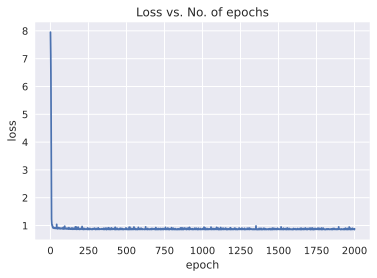

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

### Make Prediction 

In [ ]:
test_imgs, test_tabular, test_lbls = next(iter(test_loader))

with torch.no_grad(): 
    preds = model_1(test_imgs, test_tabular)

In [ ]:
yhat=torch.max(preds.data,1)  # [1]
yhat[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_errors_and_r2(y_true, y_pred):
    mean_squared_err = (mean_squared_error(y_true, y_pred))
    root_mean_squared_err = np.sqrt(mean_squared_err)
    mae = (mean_absolute_error(y_true, y_pred))
    r2 = round(r2_score(y_true, y_pred)*100,0)
    return mean_squared_err, root_mean_squared_err, mae, r2

In [ ]:
test_mean_squared_error, test_root_mean_squared_error,test_mae, test_r2_score_percentage = calculate_errors_and_r2(test_lbls, yhat[1])

print('Test Data MSE = ', test_mean_squared_error)
print('Test Data RMSE = ', test_root_mean_squared_error)
print('Test Data MAE = ', test_mae)
print('Test Data R2 = ', test_r2_score_percentage)

Test Data MSE =  62.971365937118364
Test Data RMSE =  7.935449951774529
Test Data MAE =  7.794903250728922
Test Data R2 =  -2748.0


**Save model**

In [ ]:
torch.save(model_1.state_dict(), '/root/User/_DIPLOMA/models_chp/model_1_900epoch.pth')

**Load model**

In [ ]:
model_1_loaded = RatingPredictor()
model_1_loaded.load_state_dict(torch.load('/root/User/_DIPLOMA/models_chp/model_1_900ep.pth'))


<All keys matched successfully>

### LightningModule

In [ ]:
class LitClassifier(pl.LightningModule):
    def __init__(
        self, lr: float = 1e-3, num_workers: int = 4, batch_size: int = 16,
    ):
        super().__init__()
        self.lr = lr
        self.num_workers = num_workers
        self.batch_size = batch_size

        self.conv1 = conv_block(3, 16)
        self.conv2 = conv_block(16, 32)
        self.conv3 = conv_block(32, 64)

        self.ln1 = nn.Linear(64 * 6 * 6, 16)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(16)
        self.dropout = nn.Dropout2d(0.5)
        self.ln2 = nn.Linear(16, 5)

        self.ln4 = nn.Linear(49, 10)
        self.ln5 = nn.Linear(10, 10)
        self.ln6 = nn.Linear(10, 5)
        self.ln7 = nn.Linear(10, 1)

    def forward(self, img, tab):
        img = self.conv1(img)

        img = self.conv2(img)
        img = self.conv3(img)
        img = img.reshape(img.shape[0], -1)
        img = self.ln1(img)
        img = self.relu(img)
        img = self.batchnorm(img)
        img = self.dropout(img)
        img = self.ln2(img)
        img = self.relu(img)

        tab = self.ln4(tab)
        tab = self.relu(tab)
        tab = self.ln5(tab)
        tab = self.relu(tab)
        tab = self.ln6(tab)
        tab = self.relu(tab)

        x = torch.cat((img, tab), dim=1)
        x = self.relu(x)

        return self.ln7(x)

    def training_step(self, batch, batch_idx):
        image, tabular, y = batch

        criterion = torch.nn.L1Loss()
        y_pred = torch.flatten(self(image, tabular))
        y_pred = y_pred.double()

        loss = criterion(y_pred, y)

        # tensorboard_logs = {"train_loss": loss}
        # return {"loss": loss, "log": tensorboard_logs}
        # print('>>> Loss:regression/train: ', loss)
        # rmse = torch.sqrt(loss)
        # print('>>> RMSE/train: ', rmse)
        return loss

    def validation_step(self, batch, batch_idx):
        image, tabular, y = batch

        criterion = torch.nn.L1Loss()
        y_pred = torch.flatten(self(image, tabular))
        y_pred = y_pred.double()

        val_loss = criterion(y_pred, y)
        
        # print('>>> Loss:regression/validation: ', val_loss)
        rmse = torch.sqrt(val_loss)
        # print('>>> RMSE/validation: ', rmse)
        return {"val_loss": val_loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        # tensorboard_logs = {"val_loss": avg_loss}
#         print(f'AVG VAL LOSS: {avg_loss}')
        # return {"val_loss": avg_loss, "log": tensorboard_logs}
        return {"val_loss": avg_loss}

    def test_step(self, batch, batch_idx):
        image, tabular, y = batch

        criterion = torch.nn.L1Loss()
        y_pred = torch.flatten(self(image, tabular))
        y_pred = y_pred.double()

        test_loss = criterion(y_pred, y)
        # print('>>> Test loss:', test_loss)
        # return {"test_loss": test_loss}
        # return test_loss

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        # logs = {"test_loss": avg_loss}
        # return {"test_loss": avg_loss, "log": logs, "progress_bar": logs}
        print(f'AVG TEST LOSS: {avg_loss}')
        return {"test_loss": avg_loss}
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=(self.lr))
    
    def setup(self, stage):
    
        # train

        image_data_train = ImageDataset(df=train_new, image_dir='/root/User/_DIPLOMA/data/train_covers')

        self.test_set = ImageDataset(df=test_new, image_dir='/root/User/_DIPLOMA/data/test_covers')

        self.train_set, test_dddd, self.val_set = random_split(image_data_train, [4000, 0, 658])



    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size)

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="multi_input")

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min")

In [ ]:
model = LitClassifier()

In [ ]:
trainer = pl.Trainer(default_root_dir="/root/User/_DIPLOMA/models_chp/checkpoint_ptl_model.ckpt") # , callbacks=early_stop_callback

In [ ]:
trainer.fit_loop.max_epochs=900

In [ ]:
lr_finder = trainer.tuner.lr_find(model)

In [ ]:
fig = lr_finder.plot(suggest=True, show=True)

In [ ]:
new_lr = lr_finder.suggestion()

In [ ]:
trainer.fit(model)

In [ ]:
trainer.test(model)


In [ ]:
def predict_dataloader(model, dataloader):
    predictions = []
    model.eval()
    for batch in dataloader:
        predictions.append(model(batch).detach().numpy())
    return np.vstack(predictions)

In [ ]:
predictions = predict_dataloader(model, test_loader)